In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from compton import posterior_precision_linear, shannon_expected_utility

In [2]:
fontsize = 8
black = 'k'

mpl.rcdefaults()  # Set to defaults

mpl.rc('text', usetex=True)
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['axes.edgecolor'] = black
# mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = black
mpl.rcParams['axes.linewidth']
mpl.rcParams['axes.titlesize'] = fontsize

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['xtick.color'] = black
mpl.rcParams['ytick.color'] = black
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

mpl.rcParams['hatch.linewidth'] = 0.5

mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 130

In [3]:
N = 20

x = np.linspace(0, 1, N)

m_true = 1
b_true = 1

# Feature matrix
X = np.ones((N, 2))
X[:, 1] = x

params_true = np.array([b_true, m_true])

y_true_ = m_true * x + b_true
y_true = X @ params_true

np.allclose(y_true_, y_true)

True

In [4]:
X

array([[1.        , 0.        ],
       [1.        , 0.05263158],
       [1.        , 0.10526316],
       [1.        , 0.15789474],
       [1.        , 0.21052632],
       [1.        , 0.26315789],
       [1.        , 0.31578947],
       [1.        , 0.36842105],
       [1.        , 0.42105263],
       [1.        , 0.47368421],
       [1.        , 0.52631579],
       [1.        , 0.57894737],
       [1.        , 0.63157895],
       [1.        , 0.68421053],
       [1.        , 0.73684211],
       [1.        , 0.78947368],
       [1.        , 0.84210526],
       [1.        , 0.89473684],
       [1.        , 0.94736842],
       [1.        , 1.        ]])

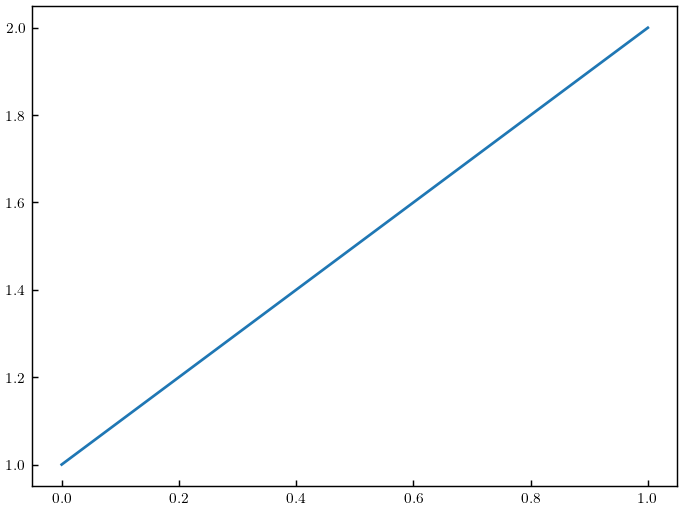

In [5]:
plt.plot(x, y_true)

In [6]:
def compute_utils(design_idx, X, cov, param_prec, param_idx=None):
    X = X[design_idx]
    cov_data = cov[design_idx][:, design_idx]
    
    if param_idx is not None:
        X = X[:, param_idx]
        param_prec = param_prec[param_idx][:, param_idx]
    
    return shannon_expected_utility(X, cov_data=cov_data, prec_p=param_prec)

In [7]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

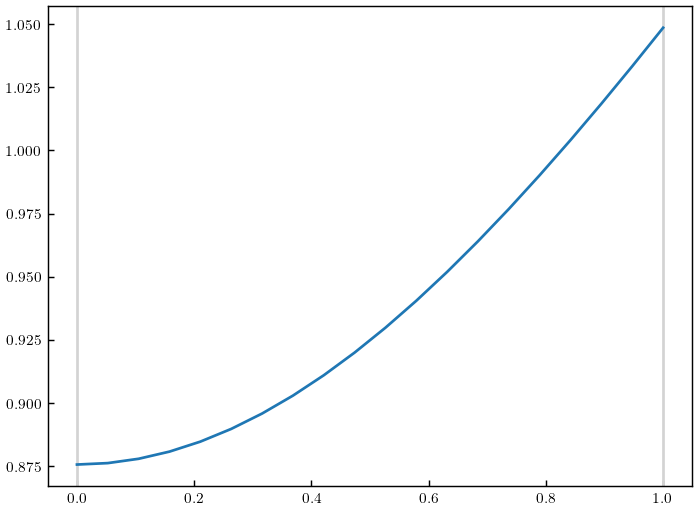

In [8]:
n_design = 2


param_idx = None

# cov_data = np.eye(N)
kernel_trunc = 0.2 * RBF(2.5)
kernel_noise = WhiteKernel(0.01)
kernel_data = kernel_trunc + kernel_noise
# kernel_data = RBF(0.2) + WhiteKernel(1)
cov_trunc = kernel_trunc(x[:, None])
cov_noise = kernel_noise(x[:, None])
cov_data = kernel_data(x[:, None])

# cov_trunc = np.sum([x[:, None]**n * x**n for n in range(2, 3)], axis=0)
# cov_trunc = 0.
# cov_noise = 0.5 * np.eye(N)
# # cov_data = kernel_data(x[:, None])
# cov_data = cov_trunc + cov_noise

# cov_data = np.eye(N)


# params_prior_cov = np.eye(len(params_true))
params_prior_cov = np.diag([1, 0.5])
params_prior_prec = np.linalg.inv(params_prior_cov)

utils_1pt = []
for one_pt_design in range(N):
    util_i = compute_utils([one_pt_design], X, cov_data, params_prior_prec, param_idx=param_idx)
    utils_1pt.append(util_i)
    
utils_1pt = np.array(utils_1pt)
opt_1pt = np.arange(N)[np.argmax(utils_1pt)]


utils_npt = []
from itertools import combinations_with_replacement, combinations

# npt_designs = np.array(list(combinations_with_replacement(range(N), n_design)))
npt_designs = np.array(list(combinations(range(N), n_design)))
# print(npt_designs)

for npt_design in npt_designs:
#     print(npt_design, X[npt_design])
#     print(npt_design, cov_data[npt_design][:, npt_design])
    util_i = compute_utils(npt_design, X, cov_data, params_prior_prec, param_idx=param_idx)
    utils_npt.append(util_i)

utils_npt = np.array(utils_npt)
# plt.plot(x, utils_npt);

opt_npt = npt_designs[np.argmax(utils_npt)]
[plt.axvline(x[opt_npt_i], 0, 1, c='lightgrey') for opt_npt_i in opt_npt]
plt.plot(x, utils_1pt);

In [9]:
opt_1pt, opt_npt

(19, array([ 0, 19]))

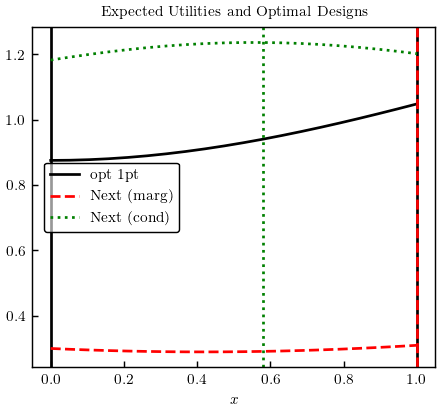

In [12]:
seq_utils_1pt_marg = []
seq_utils_1pt_cond = []

# cov_data_cond = cov_data - cov_trunc[:, [opt_1pt]] @ cov_trunc[[opt_1pt]] / cov_data[opt_1pt, opt_1pt]
# params_post_prec = posterior_precision_linear(X[[opt_1pt]], cov_data[[opt_1pt]][:, [opt_1pt]], params_prior_prec)

cov_data_cond = cov_data - cov_trunc[:, opt_npt] @ np.linalg.solve(cov_data[opt_npt][:, opt_npt], cov_trunc[opt_npt])
params_post_prec = posterior_precision_linear(X[opt_npt], cov_data[opt_npt][:, opt_npt], params_prior_prec)

for one_pt_design in range(N):
    seq_utils_1pt_marg.append(
        compute_utils([one_pt_design], X, cov_data, params_post_prec, param_idx=param_idx)
    )
    seq_utils_1pt_cond.append(
        compute_utils([one_pt_design], X, cov_data_cond, params_post_prec, param_idx=param_idx)
    )

    
seq_utils_1pt_marg = np.array(seq_utils_1pt_marg)
seq_opt_1pt_marg = np.arange(N)[np.argmax(seq_utils_1pt_marg)]

seq_utils_1pt_cond = np.array(seq_utils_1pt_cond)
seq_opt_1pt_cond = np.arange(N)[np.argmax(seq_utils_1pt_cond)]


fig, ax = plt.subplots(figsize=(4, 3.4), sharex=True, sharey=True)

ax.plot(x, utils_1pt, label='opt 1pt', c='k')
# ax.axvline(x[opt_npt], 0, 1, c='k')
[ax.axvline(x[opt_npt_i], 0, 1, c='k') for opt_npt_i in opt_npt]

ax.plot(x, seq_utils_1pt_marg, c='r', ls='--', label='Next (marg)')
ax.axvline(x[seq_opt_1pt_marg], 0, 1, c='r', ls='--')

ax.plot(x, seq_utils_1pt_cond, c='g', ls=':', label='Next (cond)')
ax.axvline(x[seq_opt_1pt_cond], 0, 1, c='g', ls=':')
ax.set_title('Expected Utilities and Optimal Designs')
ax.set_xlabel('$x$')
ax.legend()

fig.savefig('sequential_design_test.pdf')

In [11]:
white_kern = WhiteKernel(1)
white_kern(X, X)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.